In [1]:
from siar.data.datasets import Siar, SiarDatasetConfig
from siar.models.architectures.adv_vae import AdvVae

dataset_config = SiarDatasetConfig(
    return_sequence=True,
    gt_target=True,
    self_target=False
)
dataset = Siar(dataset_config)
def get_model(ckpt_path):
    model = AdvVae.load_from_checkpoint(ckpt_path)
    model.eval()
    return model
model = get_model(ckpt_path = "/home/Lukas/Documents/SIAR/cvp2/logs/adv-vae-self_reconstruction/crey4oct/checkpoints/epoch=99-step=100000.ckpt")


Skipping sequence 10610 has 7 items, but expected 10
No loss function provided. Maybe it is integrated as part of the architecture.


In [16]:
from siar.utils.visualizations import plot_dim_reduced_latent_space
import torch
import matplotlib.pyplot as plt

def plot_latent_space(model, dataset, num_sequences: int = 7):
    z_list = []
    for seq_idx in range(num_sequences):
        seq_obj = dataset.get_sequence_object(seq_idx)
        x_seq = dataset[seq_idx]
        for x in x_seq:
            x = x.unsqueeze(0)
            output = model(x.to(model.device))
            z_list.append((output["z"].detach(), str(seq_obj.id)))

    flat = torch.nn.Flatten()
    z_tensor = torch.cat([flat(z[0]) for z in z_list], dim=0)
    labels = [z[1] for z in z_list]
    plot_dim_reduced_latent_space(z_tensor, labels, show=True)

def get_element_by_idx(model, dataset, idx):
    seq_idx = idx // 10
    in_seq_idx = idx % 10
    seq = dataset[seq_idx]
    x = seq[in_seq_idx].unsqueeze(0)
    output = model(x.to(model.device))
    y_hat = output["recon_x"].cpu().detach()
    x = x.cpu().detach()
    z = output["z"].cpu().detach()
    mu = output["mu"].cpu().detach()
    std = output["std"].cpu().detach()
    return x, y_hat, z, mu, std, dataset.load_image(dataset.get_sequence_object(seq_idx).gt), str(dataset.get_sequence_object(seq_idx).id)

def get_multi_element_by_idx(model, dataset, idx_list, clip = False):
    z_list = []
    out_list = []
    x_list = []
    mu_list = []
    std_list = []
    label_list = []
    gt_list = []
    for idx in idx_list:
        x, y_hat, z, mu, std, gt, label = get_element_by_idx(model, dataset, idx)
        if clip:
            y_hat = torch.clamp(y_hat, 0, 1)
            x = torch.clamp(x, 0, 1)
            gt = torch.clamp(gt, 0, 1)
        z_list.append(z)
        x_list.append(x)
        out_list.append(y_hat)
        std_list.append(std)
        mu_list.append(mu)
        gt_list.append(gt)
        label_list.append(label)
    return torch.cat(x_list, dim=0), torch.cat(out_list, dim=0), torch.cat(z_list, dim=0), torch.cat(mu_list, dim=0), torch.cat(std_list, dim=0), torch.cat(gt_list, dim=0), label_list

def show_latent_images(model, dataset, i1 = 0, i2 = 1, use_unsampled = False, axs = None):
    x_tensor, out_tensor, z_tensor, mu_tensor, std_tensor, gt_list, label_list = get_multi_element_by_idx(model, dataset, [i1, i2], True)

    if axs is None:
        fig, axs = plt.subplots(ncols=4, nrows=2, figsize = (15,8))
        axs = axs.flat
    
    # show targets
    axs[0].imshow(x_tensor[0].permute(1, 2, 0))
    axs[0].set_title(f"Target 1 ({label_list[0]})")
    axs[7].imshow(x_tensor[1].permute(1, 2, 0))
    axs[7].set_title(f"Target 2 ({label_list[1]})")
    
    # show actual reconstructions
    axs[1].imshow(out_tensor[0].permute(1,2,0))
    axs[1].set_title("reconstruction")
    axs[6].imshow(out_tensor[1].permute(1,2,0))
    axs[6].set_title("reconstruction")

    # generate mixed latents:
#    z = model.architecture._sample_gauss(mu, std)
    z1 = z_tensor[0]*0.8 + z_tensor[1]*0.2
    z2 = z_tensor[0]*0.6 + z_tensor[1]*0.4
#    z2 = z_tensor[i1]*(-1) + z_tensor[i2]*2
    z3 = z_tensor[0]*0.4 + z_tensor[1]*0.6
    z4 = z_tensor[0]*0.2 + z_tensor[1]*0.8
#    z4 = z_tensor[i1]*(-0.5) + z_tensor[i2]*1.5


    # reconstruct the images from the mixed latents
    z1_recon = torch.clamp(model.reconstruct_from_single_latent(z1.to(model.device))[0].detach().cpu(), 0, 1)
    z2_recon = torch.clamp(model.reconstruct_from_single_latent(z2.to(model.device))[0].detach().cpu(), 0, 1)
    z3_recon = torch.clamp(model.reconstruct_from_single_latent(z3.to(model.device))[0].detach().cpu(), 0, 1)
    z4_recon = torch.clamp(model.reconstruct_from_single_latent(z4.to(model.device))[0].detach().cpu(), 0, 1)

    # and show them
    axs[2].imshow(z1_recon.permute(1,2,0))
    axs[2].set_title("80% z1 - 20% z2")
    axs[3].imshow(z2_recon.permute(1,2,0))
    axs[3].set_title("60% z1 - 40% z2")
    axs[4].imshow(z3_recon.permute(1,2,0))
    axs[4].set_title("40% z1 - 60% z2")
    axs[5].imshow(z4_recon.permute(1,2,0))
    axs[5].set_title("20% z1 - 80% z2")

    for i in range(len(axs)):
        axs[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        axs[i].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

def show_latent_images_outside(model, dataset, i1 = 0, i2 = 1, use_unsampled = False, axs = None):
    x_tensor, out_tensor, z_tensor, mu_tensor, std_tensor, gt_list, label_list = get_multi_element_by_idx(model, dataset, [i1, i2], True)

    if axs is None:
        fig, axs = plt.subplots(ncols=4, nrows=2, figsize = (15,8))
        axs = axs.flat
    
#    # show targets
#    axs[0].imshow(x_tensor[0].permute(1, 2, 0))
#    axs[0].set_title(f"Target 1 ({label_list[0]})")
#    axs[7].imshow(x_tensor[1].permute(1, 2, 0))
#    axs[7].set_title(f"Target 2 ({label_list[1]})")
    
    # show actual reconstructions
    axs[2].imshow(out_tensor[0].permute(1,2,0))
    axs[2].set_title("100% z1 + 0% z2")
    axs[5].imshow(out_tensor[1].permute(1,2,0))
    axs[5].set_title("0% z1 + 100% z2")

    # generate mixed latents:
#    z = model.architecture._sample_gauss(mu, std)
    z1 = z_tensor[0]*6/3 + z_tensor[1]*-3/3
    z2 = z_tensor[0]*4.5/3 + z_tensor[1]*-1.5/3
#    z2 = z_tensor[i1]*(-1) + z_tensor[i2]*2
    z3 = z_tensor[0]*2/3 + z_tensor[1]*1/3
    z4 = z_tensor[0]*1/3 + z_tensor[1]*2/3
#    z4 = z_tensor[i1]*(-0.5) + z_tensor[i2]*1.5
    z5 = z_tensor[0]*-1.5/3 + z_tensor[1]*4.5/3
    z6 = z_tensor[0]*-3/3 + z_tensor[1]*6/3

    # reconstruct the images from the mixed latents
    z1_recon = torch.clamp(model.reconstruct_from_single_latent(z1.to(model.device))[0].detach().cpu(), 0, 1)
    z2_recon = torch.clamp(model.reconstruct_from_single_latent(z2.to(model.device))[0].detach().cpu(), 0, 1)
    z3_recon = torch.clamp(model.reconstruct_from_single_latent(z3.to(model.device))[0].detach().cpu(), 0, 1)
    z4_recon = torch.clamp(model.reconstruct_from_single_latent(z4.to(model.device))[0].detach().cpu(), 0, 1)
    z5_recon = torch.clamp(model.reconstruct_from_single_latent(z5.to(model.device))[0].detach().cpu(), 0, 1)
    z6_recon = torch.clamp(model.reconstruct_from_single_latent(z6.to(model.device))[0].detach().cpu(), 0, 1)

    # and show them
    axs[0].imshow(z1_recon.permute(1,2,0))
    axs[0].set_title("200% z1 + -100% z2")
    axs[1].imshow(z2_recon.permute(1,2,0))
    axs[1].set_title("150% z1 + -50% z2")
    axs[3].imshow(z3_recon.permute(1,2,0))
    axs[3].set_title("66% z1 + 33% z2")
    axs[4].imshow(z4_recon.permute(1,2,0))
    axs[4].set_title("33% z1 + 66% z2")
    axs[6].imshow(z5_recon.permute(1,2,0))
    axs[6].set_title("-50% z1 + 150% z2")
    axs[7].imshow(z6_recon.permute(1,2,0))
    axs[7].set_title("-100% z1 + 200% z2")

    for i in range(len(axs)):
        axs[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        axs[i].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

def show_raw_latent_images(model, dataset, i1 = 0, axs = None):
    x_tensor, out_tensor, z_tensor, mu_tensor, std_tensor, gt_list, label_list = get_element_by_idx(model, dataset, i1)

    if axs is None:
        fig, axs = plt.subplots(ncols=4, nrows=5, figsize = (10,10))
        axs = axs.flat

    for i in range(len(axs)):
        if i < 16:
            axs[i].imshow(z_tensor[0].reshape((16,32,32))[i])
        if i == 16:
            axs[i].imshow(x_tensor[0].permute(1,2,0))
        axs[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        axs[i].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off



def plot_average_latent(model, dataset, seq_idx: int):
    l = [i+seq_idx*10 for i in range(10)]
    x_tensor, out_tensor, z_tensor, mu_tensor, std_tensor, gt_list, label_list = get_multi_element_by_idx(model, dataset, l, True)

    fig, axs = plt.subplots(ncols=4, nrows=3, figsize = (15,8))
    axs = axs.flat
    

    for i in range(10):
        axs[i].imshow(x_tensor[i].permute(1, 2, 0))
        axs[i].set_title(f"Input {i+1}")
    z_avg = z_tensor.mean(dim=0)
    x_avg_recon = torch.clamp(model.reconstruct_from_single_latent(z_avg.to(model.device))[0].cpu().detach(), 0, 1)
    axs[10].imshow(x_avg_recon.permute(1,2,0))
    axs[10].set_title(f"average latent reconstruction")
    axs[11].imshow(gt_list[:3].permute(1,2,0))
    axs[11].set_title(f"Ground Truth (GT)")
    fig.suptitle("Reconstructing Ground Truth from average latents", fontsize = 16) 
    plt.tight_layout()


## Plots for the self reconstruction

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

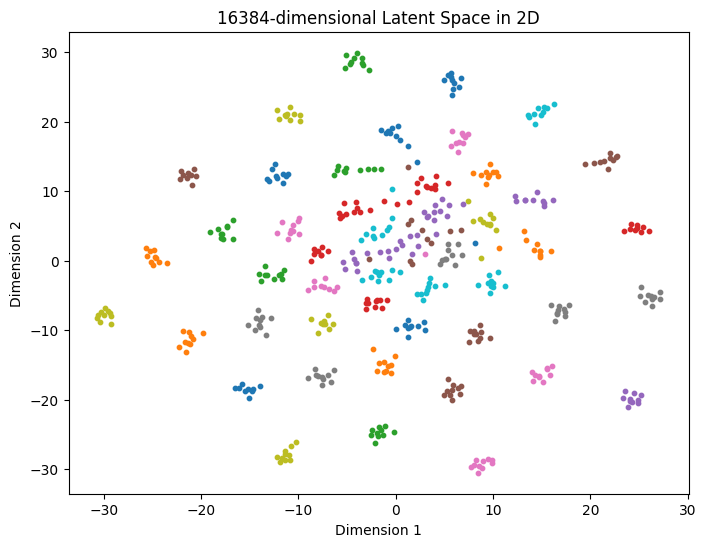

In [3]:
plot_latent_space(model = model, dataset = dataset, num_sequences = 50)

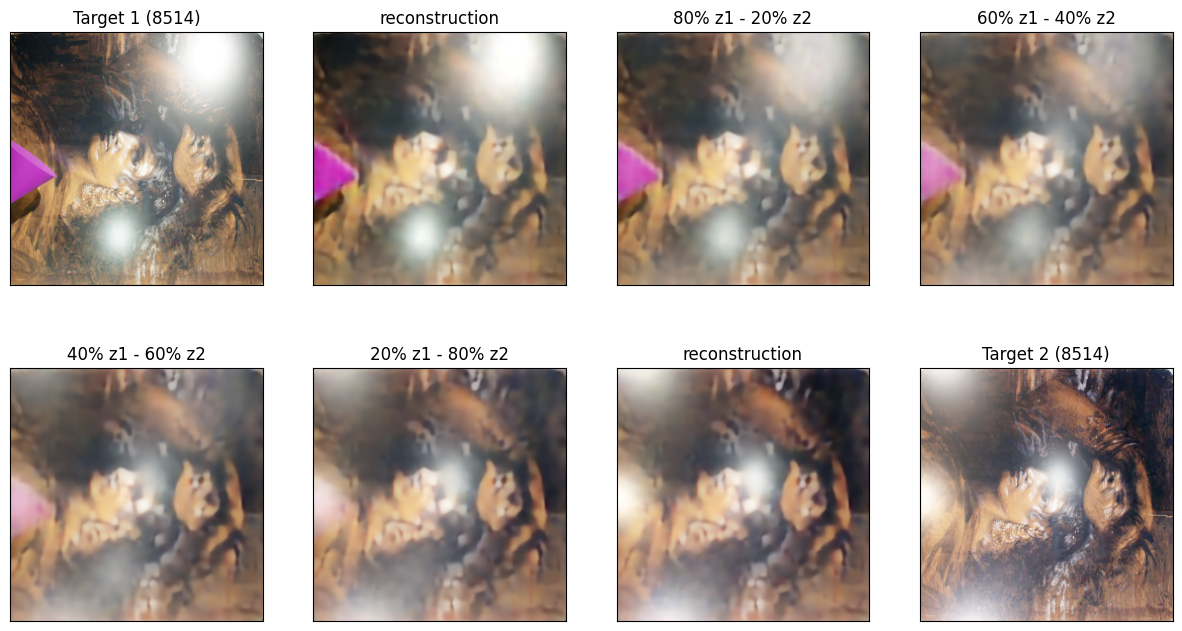

In [4]:
show_latent_images(model=model, dataset=dataset, i1 = 0, i2 = 4)

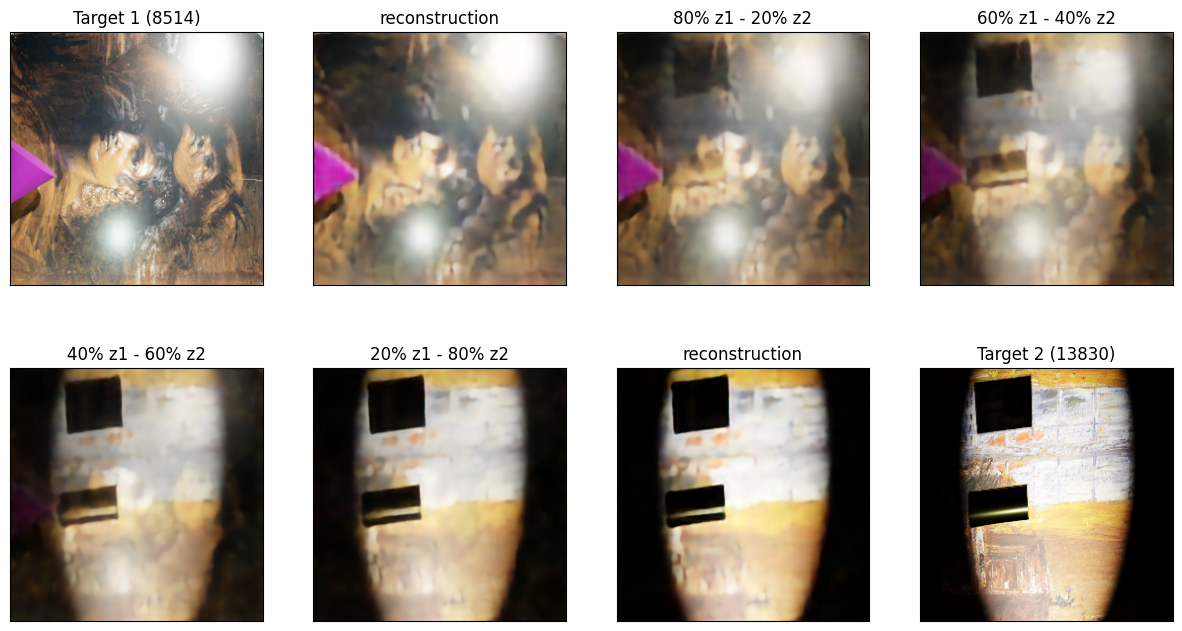

In [5]:
show_latent_images(
    model=model,
    dataset=dataset,
    i1 = 0, i2 = 21
)

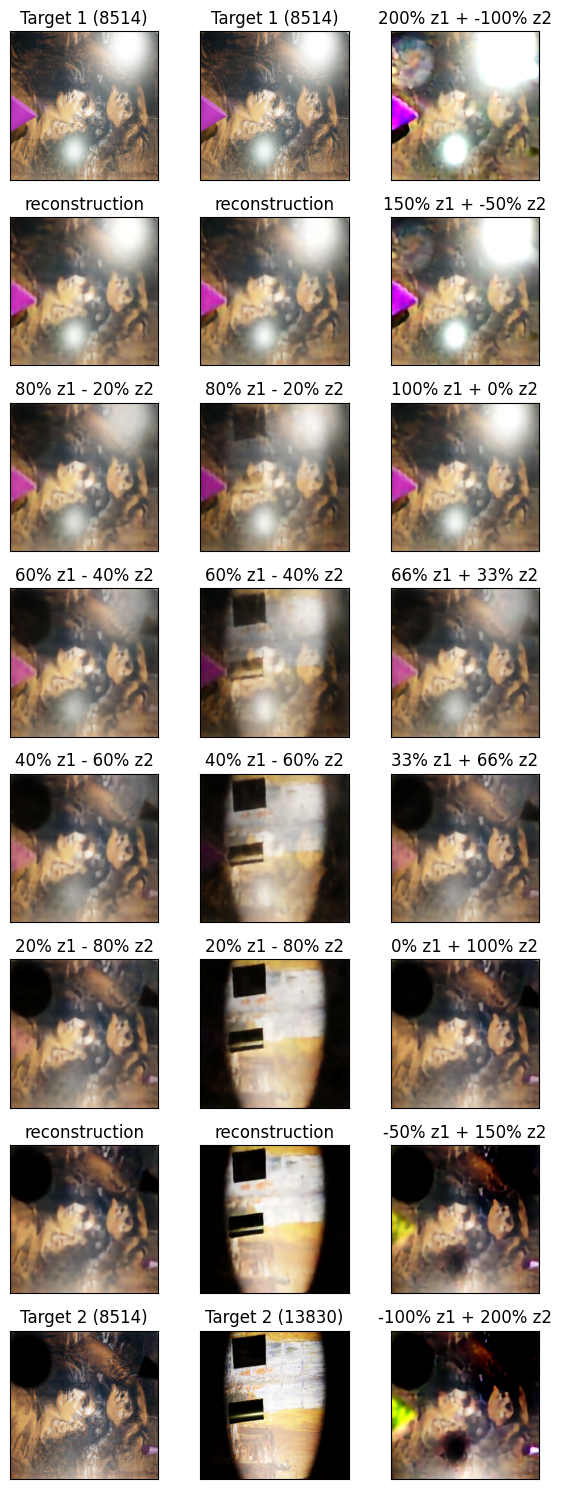

In [6]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize = (6,15))
show_latent_images(model, dataset, i1=0, i2=1, axs = axs[:,0])
show_latent_images(model, dataset, i1=0, i2=21, axs = axs[:,1])
show_latent_images_outside(model, dataset, i1=0, i2=1, axs = axs[:,2])

plt.tight_layout()

## Plots for the original reconstruction

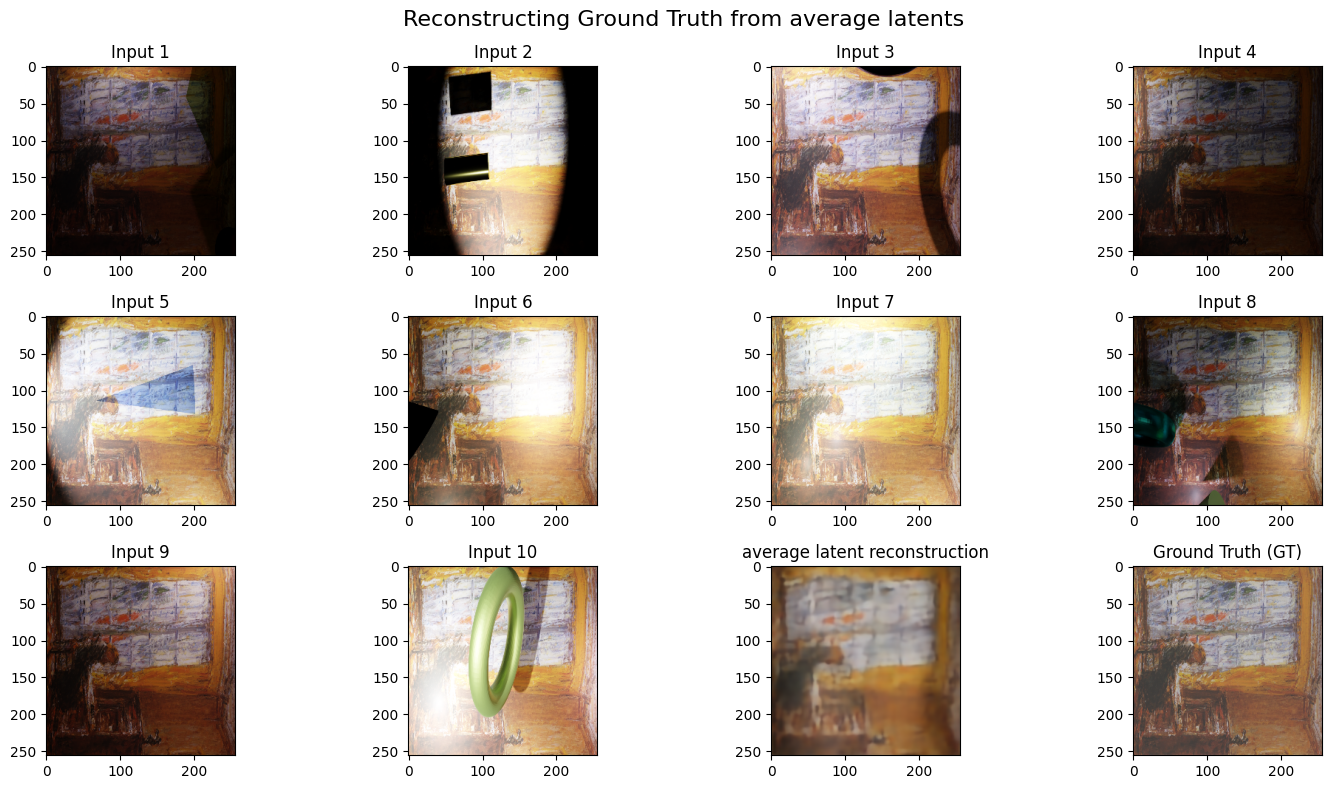

In [17]:
plot_average_latent(model, dataset, 2)

## raw latent space exploration

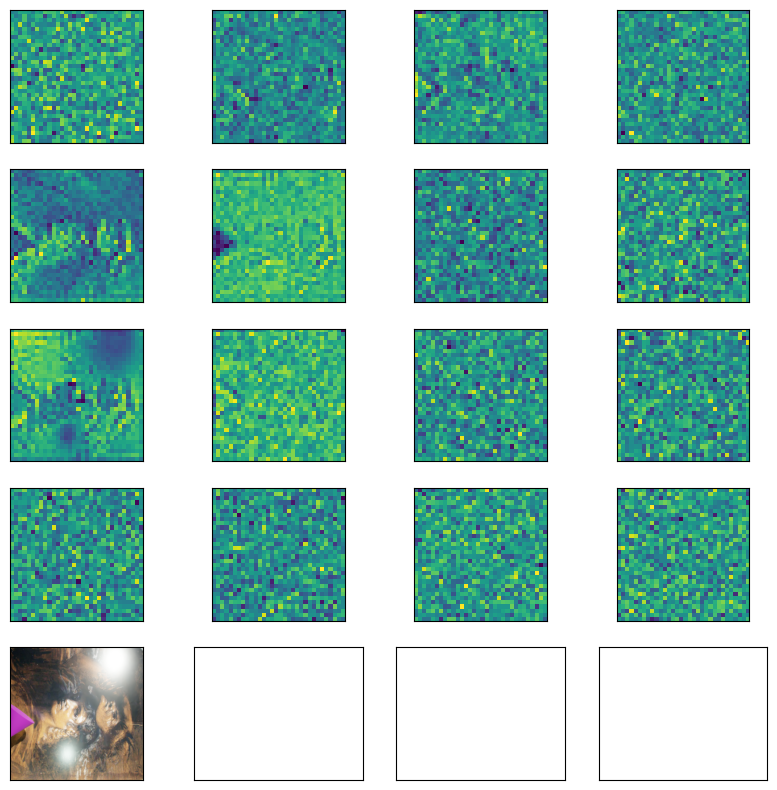

In [8]:
show_raw_latent_images(model, dataset, 0)

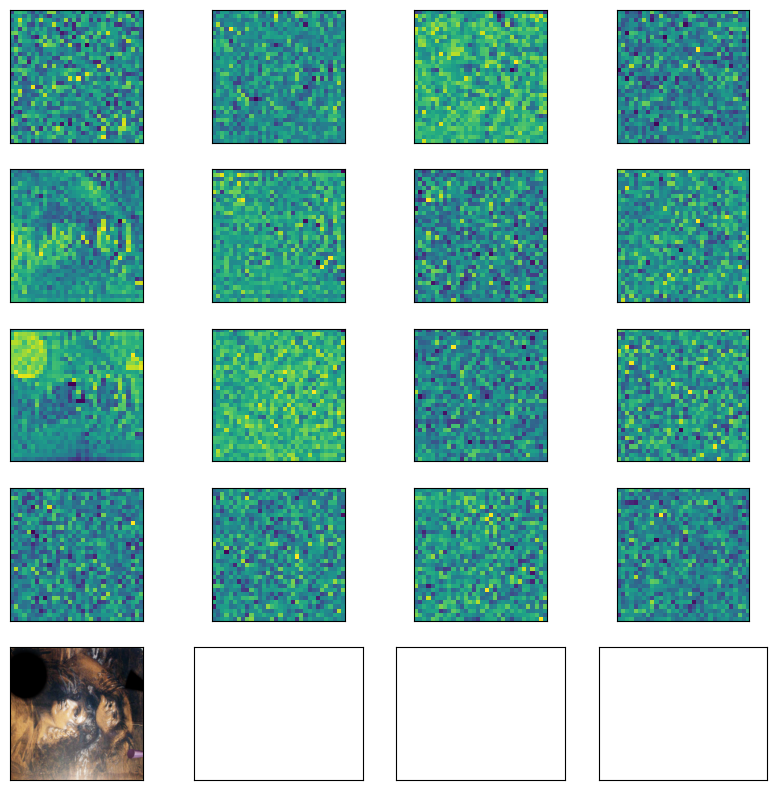

In [9]:
show_raw_latent_images(model, dataset, 1)

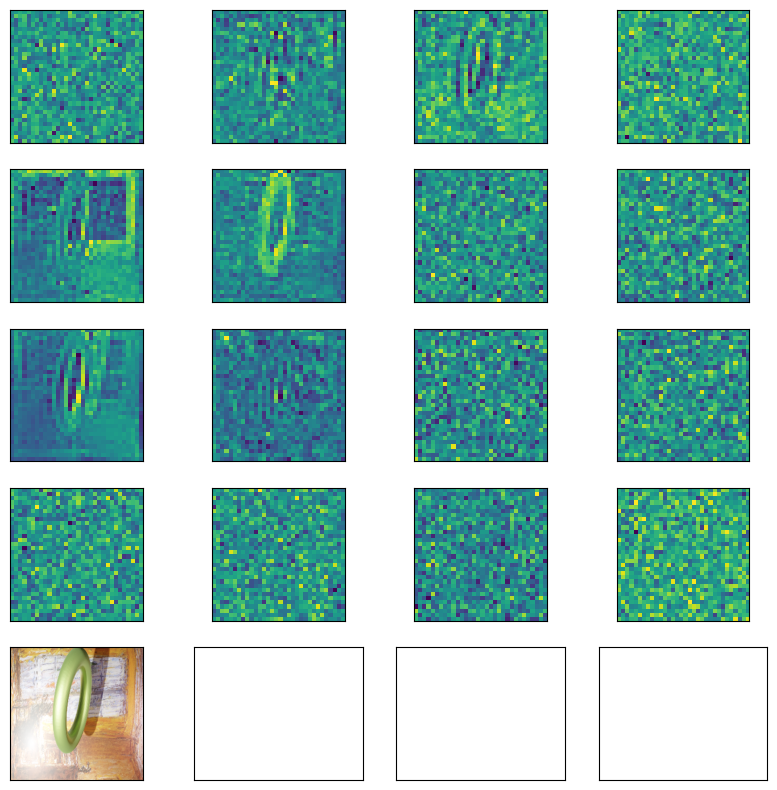

In [19]:
show_raw_latent_images(model, dataset, 29)